In [1]:
workflow = {1: 'data (prepare and load)',
            2: 'build model',
            3: 'fitting the model to data (training)', 
            4: 'making predictions and evaluting a model (inference)',
            5: 'saving and loading a model',
            6: 'putting it altogether'}

In [2]:
workflow

{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fitting the model to data (training)',
 4: 'making predictions and evaluting a model (inference)',
 5: 'saving and loading a model',
 6: 'putting it altogether'}

In [3]:
import torch
from torch import nn 
import matplotlib.pyplot as plt
import numpy as np

torch.__version__

'1.12.1+cu102'

# 1. Data - preparing and loading

 Creating some ***known*** data using linear regression formula

In [4]:
# parameters
weight = 0.7
bias = 0.3

# create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

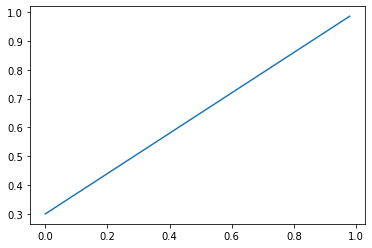

In [5]:
plt.plot(X, y)
plt.show()

How to estimate this data?

In [6]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

print(len(X_train), len(y_train), len(X_test), len(y_test))

40 40 10 10


### Visualise predictions

In [7]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    """
    Plots training data, testing data and compares predictions. 
    """
    plt.figure(figsize=(10,7))
    
    plt.scatter(train_data, train_labels, c='b', s=4, label='Training data')
    
    plt.scatter(test_data, test_labels, c='g', s=4, label='Testing data')
    
    if predictions is not None:
        plt.scatter(test_data, predictions, c='r', s=4, label='Predictions')
        
    plt.xlabel('X')
    plt.ylabel('y')
    plt.legend()

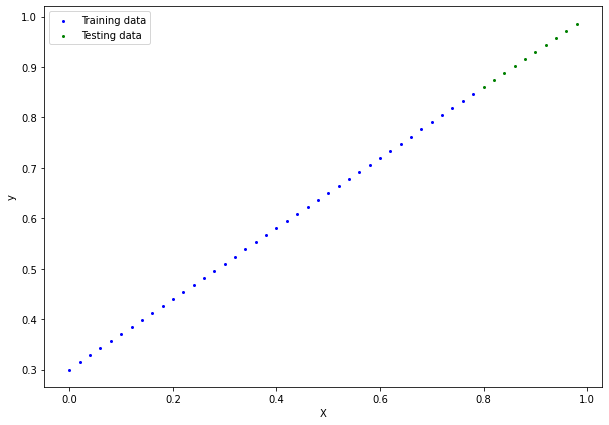

In [8]:
plot_predictions(X_train, y_train, X_test, y_test)

# 2. Build Model

1. torch.nn - contains all building blocks for computational graphs
2. torch.nn.Parameter - what parameters should our model try and learn?
3. torch.nn.Module - base class for all neural network modules. If you subclass it, you should overwrite forward()
4. torch.optim - optimisers for gradient descent
5. forward() - All nn.Module subclasses requires you to override forward

In [9]:
# Create a linear regression model class

class LinearRegressionModel(nn.Module): # class inherits from nn.Module.
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1,
                                                requires_grad=True,
                                                dtype=torch.float32))
        self.bias = nn.Parameter(torch.randn(1, 
                                             requires_grad=True,
                                             dtype=torch.float32))
    
    # Forward method to define the computation in the model
    def forward(self, x: torch.tensor) -> torch.tensor:
        return self.weights * x + self.bias

In [10]:
# create a random seed
torch.manual_seed(42)

# model initialisation
model_0 = LinearRegressionModel()

### Check out Parameters

In [11]:
# check out parameters
print(list(model_0.parameters()))

print('-'*10)
# list named parameters
model_0.state_dict()

[Parameter containing:
tensor([0.3367], requires_grad=True), Parameter containing:
tensor([0.1288], requires_grad=True)]
----------


OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions in inference mode !!!

In [12]:
y_preds = model_0(X_test)
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], grad_fn=<AddBackward0>)

In [13]:
# Make predictions using either torch.inference_mode() or torch.no_grad()
# torch.inference_mode is preferred tho.
# gradient mode is disabled, so less data need to be tracked
with torch.inference_mode():
    y_preds = model_0(X_test)
    
# with torch.no_grad():
#     y_preds = model_0(X_test)
    
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

### Visualise predictions

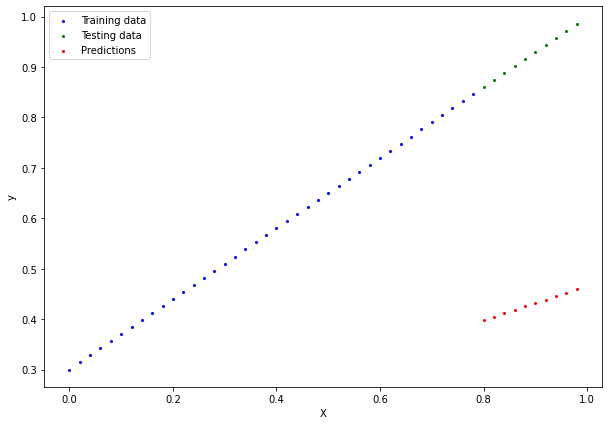

In [14]:
plot_predictions(predictions=y_preds) # lol that's very bad. so we need to train 

# 3. Train Model

1. We need to set up:
    1. **Loss function**
    2. **Optimiser**: Arguments - `params` (parameters) and `lr` (learning rate)
2. Write a training loop

### 1. Set up

In [15]:
list(model_0.parameters()), model_0.state_dict()

([Parameter containing:
  tensor([0.3367], requires_grad=True),
  Parameter containing:
  tensor([0.1288], requires_grad=True)],
 OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))]))

In [16]:
# create a random seed
torch.manual_seed(42)

# model initialisation
model_0 = LinearRegressionModel()

In [17]:
# set up a loss function (measures how wrong our model is)
loss_fun = nn.L1Loss()

# set up an optimiser (adjusts our parameters to optimise the loss fn)
optimiser = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

### 2. Training loop

0. Loop through data
1. Forward pass on data for prediction
2. Calculate the loss for made predictions
3. Optimiser zero grad
4. Loss backward - backprop
5. Optimiser step - gradient descent

In [18]:
# An epoch is one loop through the data
epochs = 150 # hyperparameter

# Track different values
epoch_count = []
loss_values = []
test_loss_values = []

# Loop through data
for epoch in range(epochs):
    
     # Training:: set model to training mode
    model_0.train() # now (requires_grad=True), track gradients
    
    #1. Forward pass
    y_pred = model_0(X_train)
    
    # 2. Calculate the loss
    loss = loss_fun(y_pred, y_train)
    # print(f'Train Loss:{loss}')
    
    # 3. Optimiser zero grad
    optimiser.zero_grad()
    
    # 4. Perform backprop
    loss.backward()
    
    # 5. Step the optimiser / gradient descent
    optimiser.step()
    
    # Testing:: 
    model_0.eval() # turns off setting you don't need for testing
    
    # turn off tracking gradients, go to inference_mode - check their tweet on this!
    # https://twitter.com/PyTorch/status/1437838231505096708?s=20
    with torch.inference_mode():
        
        # 1. Do the forward pass
        test_pred = model_0(X_test)
        
        # 2. Calculate the loss
        test_loss = loss_fun(test_pred, y_test)
    
    # Track progress 
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(f'Epoch: {epoch} | Train Loss:{loss} | Test Loss: {test_loss}')
        
print(model_0.state_dict())

Epoch: 0 | Train Loss:0.31288138031959534 | Test Loss: 0.48106518387794495
Epoch: 10 | Train Loss:0.1976713240146637 | Test Loss: 0.3463551998138428
Epoch: 20 | Train Loss:0.08908725529909134 | Test Loss: 0.21729660034179688
Epoch: 30 | Train Loss:0.053148526698350906 | Test Loss: 0.14464017748832703
Epoch: 40 | Train Loss:0.04543796554207802 | Test Loss: 0.11360953003168106
Epoch: 50 | Train Loss:0.04167863354086876 | Test Loss: 0.09919948130846024
Epoch: 60 | Train Loss:0.03818932920694351 | Test Loss: 0.08886633068323135
Epoch: 70 | Train Loss:0.03476089984178543 | Test Loss: 0.0805937647819519
Epoch: 80 | Train Loss:0.03132382780313492 | Test Loss: 0.07232122868299484
Epoch: 90 | Train Loss:0.02788739837706089 | Test Loss: 0.06473556160926819
Epoch: 100 | Train Loss:0.024458957836031914 | Test Loss: 0.05646304413676262
Epoch: 110 | Train Loss:0.021020207554101944 | Test Loss: 0.04819049686193466
Epoch: 120 | Train Loss:0.01758546568453312 | Test Loss: 0.04060482233762741
Epoch: 130

### 3. Visualise the training

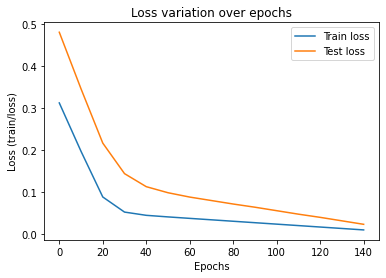

In [19]:
# Plot loss curves 
# IMPORTANT: note that the loss values are converted from tensor to numpy to plot them!
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label='Train loss')
plt.plot(epoch_count, np.array(test_loss_values), label='Test loss')
plt.title('Loss variation over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (train/loss)')
plt.legend()
plt.show()

# 4. Making Predictions

In [20]:
with torch.inference_mode():
        y_preds = model_0(X_test)

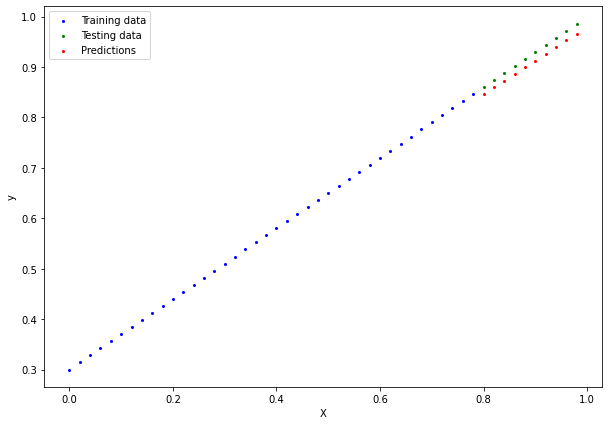

In [21]:
plot_predictions(predictions=y_preds) # after training, the predictions are a lot better!

In [22]:
print('parameters after training:', model_0.state_dict())
print()
print('og parameters:', weight, bias)

parameters after training: OrderedDict([('weights', tensor([0.6638])), ('bias', tensor([0.3153]))])

og parameters: 0.7 0.3


# 5. Saving/Loading model 

1. `torch.save()`: pickles your model
2. `torch.load()`: loads saved model
3. `torch.nn.Module.load_state_dict()`: loads model's saved state dictionary

Resource: https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference

In [23]:
# Saving our PyTorch model
from pathlib import Path

# 1. Create a models direction
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = '01_pytorch_workflow_model_0.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f'Saving model to: {MODEL_SAVE_PATH}')

# 3. Save the model state dict
torch.save(obj=model_0.state_dict(), 
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [24]:
# Loading the model:
# Since we saved our model's state_dict() only, 
# we'll create a new instance of the model class and load 
# the saved state_dict() into it.

# instantiate model
loaded_model_0 = LinearRegressionModel()

# load state_dict
loaded_model_0.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

In [25]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6638])), ('bias', tensor([0.3153]))])

In [26]:
# make predictions with loadd model

loaded_model_0.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)

print(loaded_model_preds == y_preds)

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])


In [27]:
# saving entire model

# torch.save(model_0, MODEL_SAVE_PATH)
# loaded_model_0 = torch.load(MODEL_SAVE_PATH)
# loaded_model_0.eval()
# with torch.inference_mode():
#     loaded_model_preds = loaded_model_0(X_test)

# print(loaded_model_preds == y_preds)

# 6. Putting it altogether

In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device --", device)

Using device -- cuda


## 6.1 Data

In [29]:
weight = 0.7
bias = 0.3

start = 0
end = 1 
step = 0.02

# features
X = torch.arange(start, end, step).unsqueeze(dim=1)
# X = torch.arange(start, end, step) # YOU WILL GET DIM ERROR WITH THIS. SO SQUEEZE!!

# labels
y = weight * X + bias

In [30]:
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [31]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

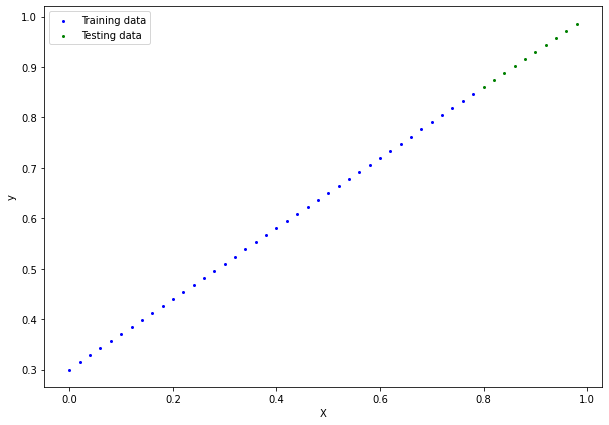

In [32]:
plot_predictions(X_train, y_train, X_test, y_test)

## 6.2 Building a PyTorch linear model

In [33]:
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() to create model parameters
        self.linear_layer = nn.Linear(in_features=1,
                                      out_features=1)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)
    
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [34]:
X_train[:5], y_train[:5]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560]]))

## 6.3 Create device agnostic code 

### Parameters

In [35]:
next(model_1.parameters()).device

device(type='cpu')

In [36]:
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

### Data

In [37]:
X_train.device, X_test.device, y_train.device, y_test.device

(device(type='cpu'),
 device(type='cpu'),
 device(type='cpu'),
 device(type='cpu'))

In [38]:
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

In [39]:
X_train.device, X_test.device, y_train.device, y_test.device

(device(type='cuda', index=0),
 device(type='cuda', index=0),
 device(type='cuda', index=0),
 device(type='cuda', index=0))

## 6.4 Training

In [40]:
torch.manual_seed(42)
LR=0.01
EPOCHS = 200

loss_fn = nn.L1Loss()
optimiser = torch.optim.SGD(params=model_1.parameters(),
                            lr=LR)

In [41]:
test_losses = []
train_losses = []

for epoch in range(EPOCHS):
    model_1.train()
    
    #1. forward pass
    y_pred = model_1(X_train)
    
    # 2. Calculate the loss
    loss = loss_fn(y_pred, y_train)
    train_losses.append(loss)
    
    # 3. Optimiser zero grad 
    optimiser.zero_grad()
    
    # 4. Backprop
    loss.backward()
    
    # 5. Optimiser step
    optimiser.step()
    
    # Testing
    model_1.eval()
    
    with torch.inference_mode():
        test_pred = model_1(X_test)
        
        test_loss = loss_fn(test_pred, y_test)
        test_losses.append(test_loss)
        
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")
        

Epoch: 0 | Loss: 0.5551779866218567 | Test Loss: 0.5739762187004089
Epoch: 10 | Loss: 0.439968079328537 | Test Loss: 0.4392664134502411
Epoch: 20 | Loss: 0.3247582018375397 | Test Loss: 0.30455657839775085
Epoch: 30 | Loss: 0.20954833924770355 | Test Loss: 0.16984669864177704
Epoch: 40 | Loss: 0.09433845430612564 | Test Loss: 0.03513690456748009
Epoch: 50 | Loss: 0.023886388167738914 | Test Loss: 0.04784907028079033
Epoch: 60 | Loss: 0.019956795498728752 | Test Loss: 0.045803118497133255
Epoch: 70 | Loss: 0.016517987474799156 | Test Loss: 0.037530567497015
Epoch: 80 | Loss: 0.013089174404740334 | Test Loss: 0.02994490973651409
Epoch: 90 | Loss: 0.009653178043663502 | Test Loss: 0.02167237363755703
Epoch: 100 | Loss: 0.006215683650225401 | Test Loss: 0.014086711220443249
Epoch: 110 | Loss: 0.00278724217787385 | Test Loss: 0.005814164876937866
Epoch: 120 | Loss: 0.0012645035749301314 | Test Loss: 0.013801801018416882
Epoch: 130 | Loss: 0.0012645035749301314 | Test Loss: 0.013801801018416

In [42]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

### Plotting predictions

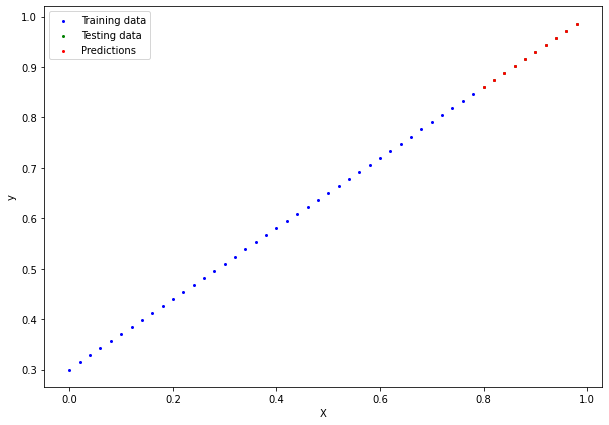

In [43]:
with torch.inference_mode():
        y_preds = model_1(X_test)
        
plot_predictions(predictions=y_preds.cpu())

In [44]:
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

## 6.4 Save and Load Model

In [48]:
from pathlib import Path

# 1. create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to:{MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to:models/01_pytorch_workflow_model_1.pth


In [52]:
# Load model

# create instance
loaded_model_1 = LinearRegressionModelV2()

# load state dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# move to device
loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [53]:
next(loaded_model_1.parameters()).device

device(type='cuda', index=0)

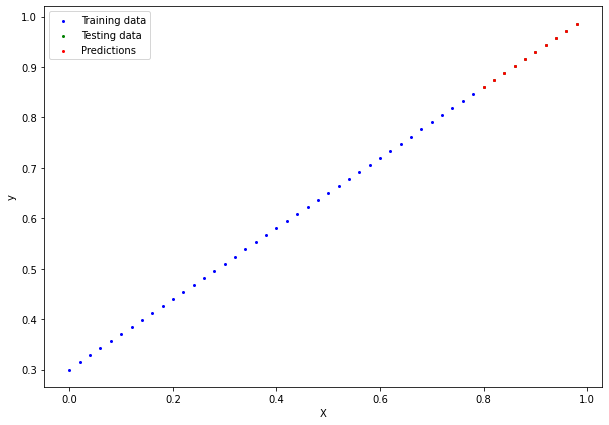

In [56]:
# Evaluate loaded model
loaded_model_1.eval()

with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
    
plot_predictions(predictions=loaded_model_1_preds.cpu())